**Introdução**

Nesse case vamos trabalhar com um dataset para classificação binária com desbalanceamento de dados.<br>
Há uma grande discrepância entre a quantidade de 0 e 1 em nossas variáveis targets.<br>
Um algoritmo que escolhe sempre zero terá uma alta accuracy, mas não resolve nosso problema.<br>
Temos a estratégia de oversampling, undersampling ou SMOTE (basicamente fabricar artificialmente novas entradas com KNN) para solucionar essa dificuldade.<br>
Vamos explorar o dataset com EDA para atacar o problema, vamos tratar os dados, modelar, validar nosso modelo e fazer uma previsão.

# BLU365

## Sobre a BLU365

A BLU365 é uma plataforma de negociação fácil, intuitiva e digital para seus clientes renegociarem suas dívidas e ficarem no azul.

Com atuação em diferentes segmentos e indústrias, a BLU365 já efetivou milhares de negociações online, sempre buscando entender o perfil de cada cliente antes de propor uma negociação. Garantindo assim, uma maior eficiência operacional e efetividade em resultados.

## Como funciona

O cliente que possui uma dívida com uma empresa parceira recebe um SMS convidando-o a entrar na plataforma da BLU365 para renegociar sua dívida. Periodicamente outros SMS sao enviados relembrando e incentivando o cliente a acessar a plataforma. 

## Sobre os dados

Os dados consistem  de um arquivo de 60MB em .xslx em duas páginas. Na pagina1 se encontram os dados em si, e na página2 está a descrições das colunas do dataset. Para cada cliente é gravado no dataset o histórico dos SMS enviados, o valor da divida, a quantidade de acesso à plataforma e o perfil do cliente.

## Objetivo

Desejamos escolher uma estratégia para escolher para quem devemos mandar os sms para estimular o acesso à plataforma e o fechamento de acordos. Para isso vamos nos utilizar das ferramentas de Data Science e Machine Learning para prever e otimizar o envio dos SMS.

In [1]:
#importing the libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta,date

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# data visualization
import seaborn as sns
sns.set(style="white")
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

import warnings
warnings.filterwarnings('ignore')

**Getting the data**

In [2]:
#setting to see full non-truncated df
pd.set_option('display.max_columns', None) 
data = pd.read_csv("dataset/dataset_estudodecaso.csv")
data_raw= data

## Exploratory Data Analysis - EDA

**Looking at the data**

In [3]:
data.head()

,datadisparo,ddd,sms_entregue,sms_enviado,sms_naoentregue,sms_rejeitado,sms_invalido,data_atraso,valor,operadora,qtd_hist_acessos,data_maisrecente_acesso,data_maisantiga_acesso,sms_total_tent,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo
0,19/5/2020,62,0,0,0,0,0,24/5/2019,"126,21",Claro,0,NaN,NaN,0,22.0,M,H,H,H,NaN,0,0
1,27/4/2020,67,3,0,0,0,0,14/4/2017,"244,29",Vivo,0,NaN,NaN,3,56.0,F,D,H,D,ATE 2 SM,0,0
2,14/5/2020,51,1,0,0,0,0,4/9/2019,51,Claro,0,NaN,NaN,1,45.0,M,B,H,B,ATE 2 SM,0,0
3,13/5/2020,51,0,0,0,0,0,14/11/2019,"307,909999999999",Tim,0,NaN,NaN,0,35.0,F,B,H,B,4 A 10 SM,0,0
4,25/5/2020,62,0,0,12,0,0,14/3/2017,"154,119999999999",Tim,0,NaN,NaN,12,43.0,F,A,H,A,NaN,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686383 entries, 0 to 686382
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   datadisparo              686383 non-null  object 
 1   ddd                      686383 non-null  int64  
 2   sms_entregue             686383 non-null  int64  
 3   sms_enviado              686383 non-null  int64  
 4   sms_naoentregue          686383 non-null  int64  
 5   sms_rejeitado            686383 non-null  int64  
 6   sms_invalido             686383 non-null  int64  
 7   data_atraso              686383 non-null  object 
 8   valor                    686383 non-null  object 
 9   operadora                686383 non-null  object 
 10  qtd_hist_acessos         686383 non-null  int64  
 11  data_maisrecente_acesso  77512 non-null   object 
 12  data_maisantiga_acesso   77512 non-null   object 
 13  sms_total_tent           686383 non-null  int64  
 14  idad

In [5]:
data.columns

Index(['datadisparo', 'ddd', 'sms_entregue', 'sms_enviado', 'sms_naoentregue',
       'sms_rejeitado', 'sms_invalido', 'data_atraso', 'valor', 'operadora',
       'qtd_hist_acessos', 'data_maisrecente_acesso', 'data_maisantiga_acesso',
       'sms_total_tent', 'idade', 'genero', 'compradoronline',
       'vendedoronline', 'utilizacaoweb', 'rendaestimada', 'acesso', 'acordo'],
      dtype='object')

O dataset possui 686383 entradas,  21 colunas, com os seguintes dtypes: float64(1), int64(10), object(11), temos 1 coluna em formato float, **idade**, que poderia estar no formato int. A coluna **valor** está em formato object, ou seja está salvo como texto, temos datas no formato object, sabemos que **genero**, **compradoronline**, **vendedoronline** são categoricos, temos algumas colunas com valores faltando, vamos ver.

In [6]:
data.describe()

,ddd,sms_entregue,sms_enviado,sms_naoentregue,sms_rejeitado,sms_invalido,qtd_hist_acessos,sms_total_tent,idade,acesso,acordo
count,686383.000000,686383.000000,686383.000000,686383.000000,686383.000000,686383.0,686383.000000,686383.000000,684648.000000,686383.000000,686383.000000
mean,54.100716,2.225027,0.050928,0.938616,0.002046,0.0,0.182840,3.208181,40.644479,0.027453,0.003374
std,11.441091,3.472402,0.649311,2.474068,0.185847,0.0,0.655077,3.755364,14.697298,0.163398,0.057990
min,11.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,6.000000,0.000000,0.000000
25%,44.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,29.000000,0.000000,0.000000
50%,54.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,38.000000,0.000000,0.000000
75%,62.000000,3.000000,0.000000,0.000000,0.000000,0.0,0.000000,5.000000,49.000000,0.000000,0.000000
max,99.000000,23.000000,20.000000,22.000000,18.000000,0.0,20.000000,23.000000,136.000000,1.000000,1.000000


Olhando rapidamente temos uma idade de 136 anos, a pessoa mais velha do mundo viveu até 122 anos, e a mais velha viva tem 117 anos entao temos valores outlier incorretos. (Uma possibilidade para a idade é que ocorreu erro de digitação, ie 136 ao inves de 36). Da mesma forma idade de 6 anos não faz sentido.

**Missing Values**

In [7]:
total = data.isnull().sum().sort_values(ascending=False)
percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
data_maisantiga_acesso,608871,88.7
data_maisrecente_acesso,608871,88.7
rendaestimada,165900,24.2
idade,1735,0.3
utilizacaoweb,1733,0.3
vendedoronline,1733,0.3
compradoronline,1733,0.3
genero,1733,0.3
acordo,0,0.0
sms_invalido,0,0.0


O que chama a atenção é que temos o mesmo número de **data_maisantiga_acesso** e **data_maisrecente_acesso**, talvez clientes que nunca acessaram a plataforma. Para 4 colunas temos o mesmo número de dados faltosos, idade tem 2 entradas a mais faltando do que essas 4 colunas. Precisamos investigar melhor a natureza desses dados faltosos. Vamos visualizar.

In [8]:
#data[(data['genero']!='M') & (data['genero']!='F') & (data['genero']!='U')]

1733 entradas com 5 valores faltando

Vamos conhecer o perfil dos clientes e dos clientes que acessaram

In [9]:
data_acesso=data[data['acesso']==1]
data_acordo=data[data['acordo']==1]

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

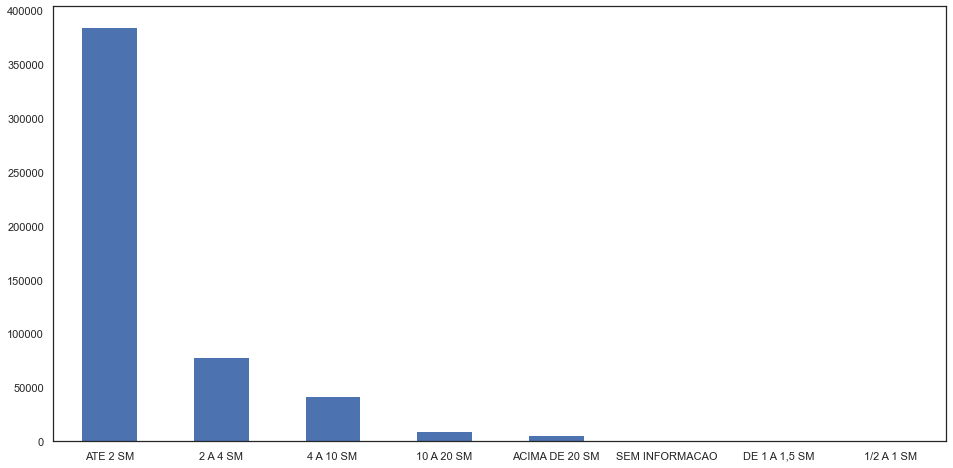

In [10]:
plt.figure(figsize=(16,8)) 
data.rendaestimada.value_counts().plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

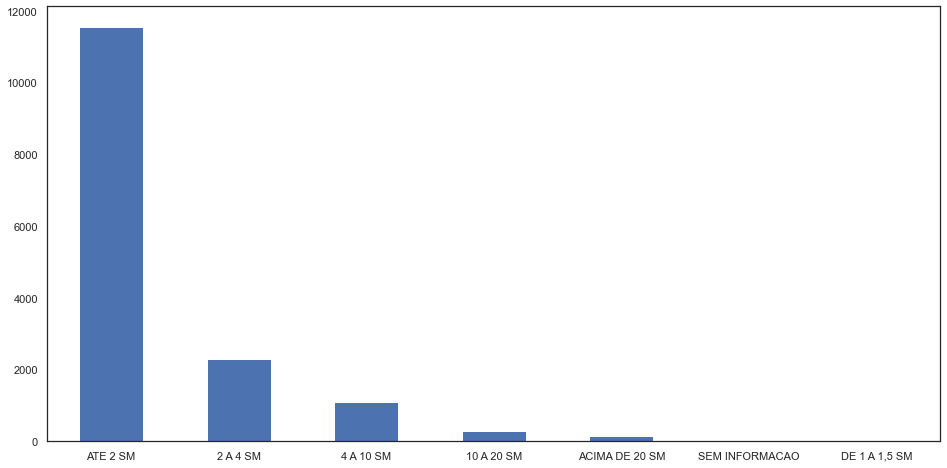

In [11]:
plt.figure(figsize=(16,8)) 
data_acesso.rendaestimada.value_counts().plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

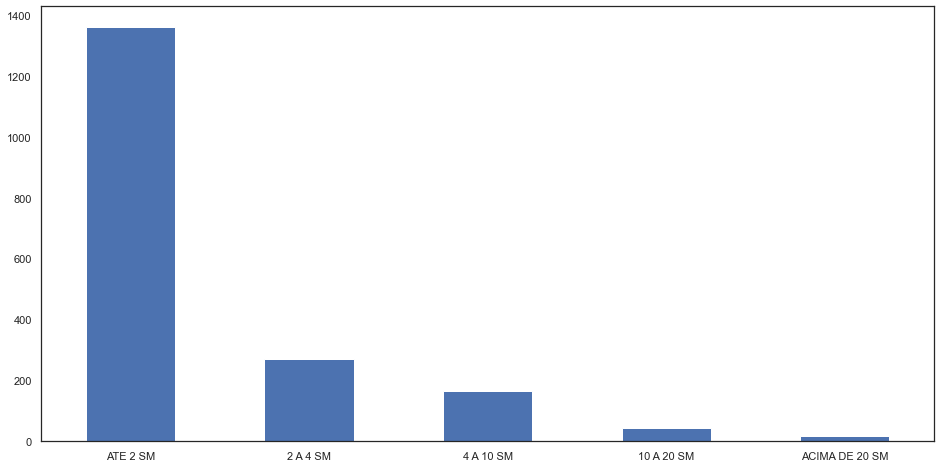

In [12]:
plt.figure(figsize=(16,8)) 
data_acordo.rendaestimada.value_counts().plot.bar()
plt.xticks(rotation=0)

Ninguem com rendas de '1/2 a 1 SM' e 'SEM INFORMACAO' fechou acordo.

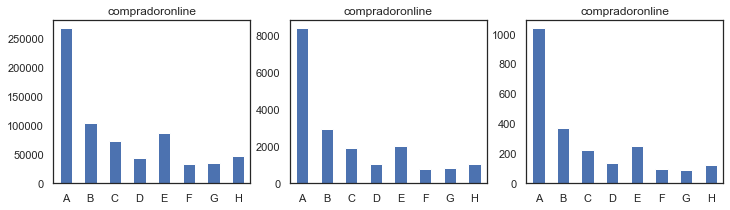

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,3))

data.compradoronline.value_counts().sort_index().plot.bar(ax = ax1,subplots=True)
data_acesso.compradoronline.value_counts().sort_index().plot.bar(ax = ax2,subplots=True)
data_acordo.compradoronline.value_counts().sort_index().plot.bar(ax = ax3,subplots=True)

for ax in fig.axes:
    ax.tick_params(labelrotation=0)

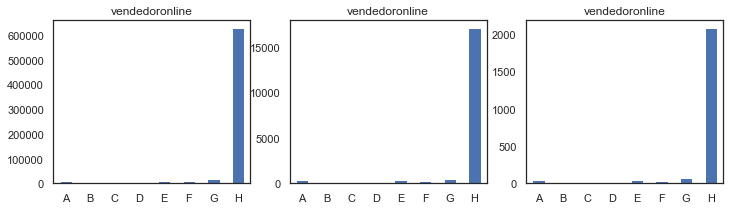

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,3))

data.vendedoronline.value_counts().sort_index().plot.bar(ax = ax1,subplots=True)
data_acesso.vendedoronline.value_counts().sort_index().plot.bar(ax = ax2,subplots=True)
data_acordo.vendedoronline.value_counts().sort_index().plot.bar(ax = ax3,subplots=True)

for ax in fig.axes:
    ax.tick_params(labelrotation=0)

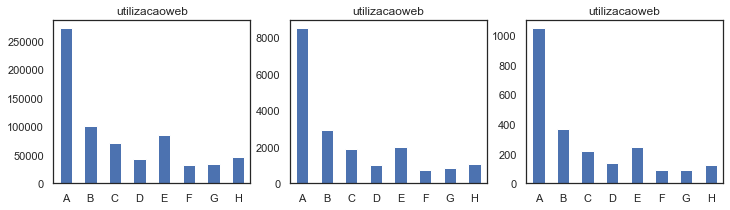

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,3))

data.utilizacaoweb.value_counts().sort_index().plot.bar(ax = ax1,subplots=True)
data_acesso.utilizacaoweb.value_counts().sort_index().plot.bar(ax = ax2,subplots=True)
data_acordo.utilizacaoweb.value_counts().sort_index().plot.bar(ax = ax3,subplots=True)

for ax in fig.axes:
    ax.tick_params(labelrotation=0)

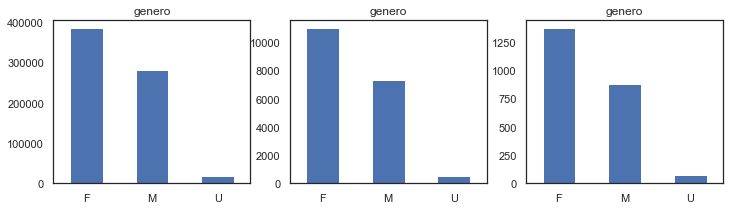

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,3))

data.genero.value_counts().sort_index().plot.bar(ax = ax1,subplots=True)
data_acesso.genero.value_counts().sort_index().plot.bar(ax = ax2,subplots=True)
data_acordo.genero.value_counts().sort_index().plot.bar(ax = ax3,subplots=True)

for ax in fig.axes:
    ax.tick_params(labelrotation=0)

In [17]:
data.genero.value_counts()

F    385389
M    280296
U     18965
Name: genero, dtype: int64

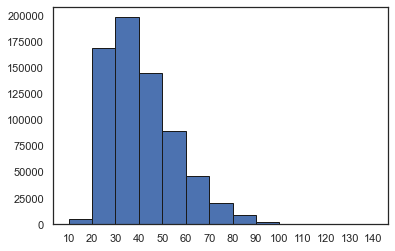

In [18]:
bins= [10,20,30,40,50,60,70,80,90,100,110,120,130,140]
plt.hist(data.idade, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.show()

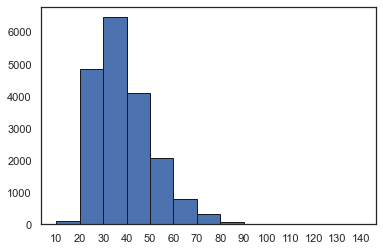

In [19]:
bins= [10,20,30,40,50,60,70,80,90,100,110,120,130,140]
plt.hist(data_acesso.idade, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.show()

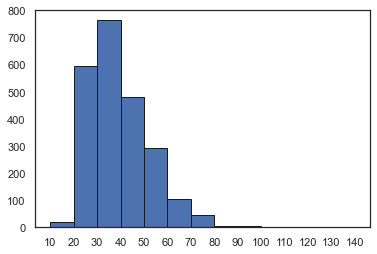

In [20]:
bins= [10,20,30,40,50,60,70,80,90,100,110,120,130,140]
plt.hist(data_acordo.idade, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.show()

A maioria dos clientes recebe até 2 SM, A  classifição mais comum para compradoronline foi A, a maior classificação. Quase a totalidade foi classificado como vendedoronline H, a pior classificação. Novamente a classificação mais comum para utilizaçãoweb foi A, a maior classificação. Temos que 58% são mulheres e 42% são homens, e olhando a distribuição de idades, em primeiro estao os clientes de 30 a 40 anos, seguidos por de 30 a 20 e de 40 a 50. As distribuições para quem acessou ou fechou acordo foi similar a de todo o dataset. As variaveis visualizadas, com exceção para renda, parecem não afetar o acesso e acordo. 

In [21]:
data.operadora.unique()

array(['Claro', 'Vivo', 'Tim', 'Oi', 'Nextel', 'Outros'], dtype=object)

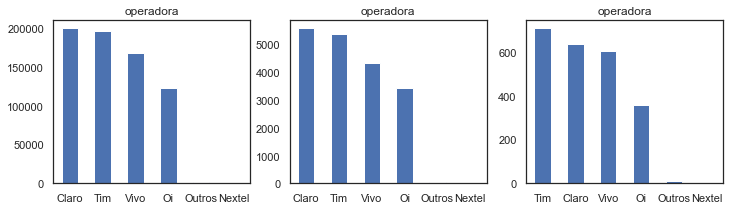

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,3))

data.operadora.value_counts().plot.bar(ax = ax1,subplots=True)
data_acesso.operadora.value_counts().plot.bar(ax = ax2,subplots=True)
data_acordo.operadora.value_counts().plot.bar(ax = ax3,subplots=True)

for ax in fig.axes:
    ax.tick_params(labelrotation=0)

Temos as 4 maiores operadoras tem mais de 100k clientes, com Claro e Tim com quase 200k clientes cada. Uma maneira de otimizar o orçamento é fechar parceria com essas operadoras para diminuir o custo dos sms.

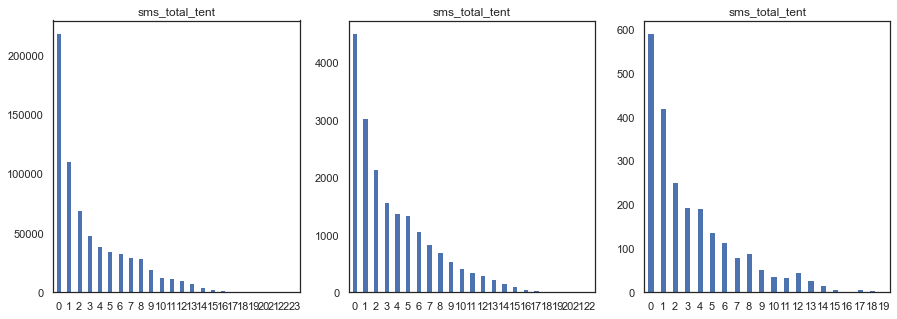

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

data.sms_total_tent.value_counts().sort_index().plot.bar(ax = ax1,subplots=True)
plt.xticks(rotation=0)
data_acesso.sms_total_tent.value_counts().sort_index().plot.bar(ax = ax2,subplots=True)
plt.xticks(rotation=0)
data_acordo.sms_total_tent.value_counts().sort_index().plot.bar(ax = ax3,subplots=True)
plt.xticks(rotation=0)

for ax in fig.axes:
    ax.tick_params(labelrotation=0)

Não há acordo com mais de 19 sms_total_tent

In [24]:
#data.sms_total_tent.value_counts()

In [25]:
#data[data['sms_total_tent']>0].count()

Para 461035 entradas já foi enviado 1 sms.

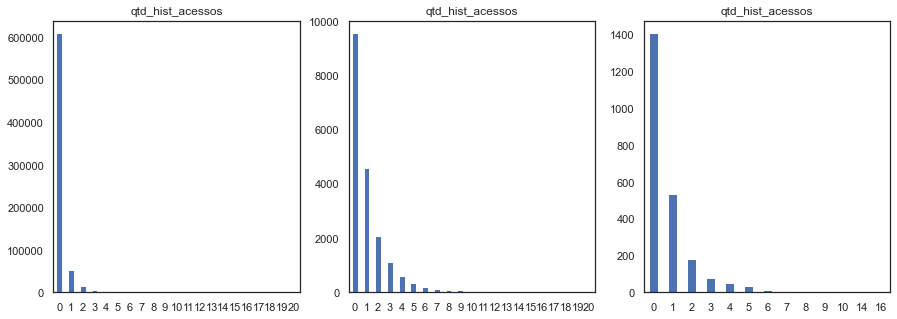

In [26]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

data.qtd_hist_acessos.value_counts().sort_index().plot.bar(ax = ax1,subplots=True)
plt.xticks(rotation=0)
data_acesso.qtd_hist_acessos.value_counts().sort_index().plot.bar(ax = ax2,subplots=True)
plt.xticks(rotation=0)
data_acordo.qtd_hist_acessos.value_counts().sort_index().plot.bar(ax = ax3,subplots=True)
plt.xticks(rotation=0)

for ax in fig.axes:
    ax.tick_params(labelrotation=0)

Temos acordos com qtd_hist_acessos==0

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 <a list of 67 Text major ticklabel objects>)

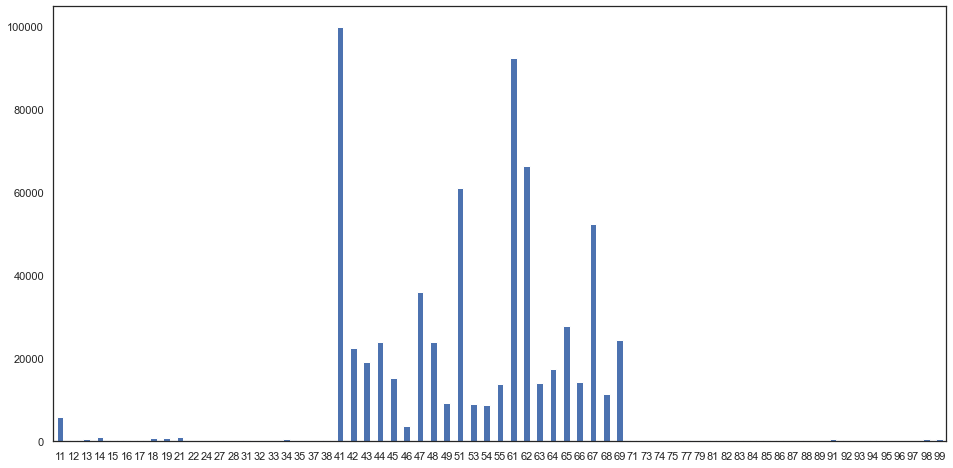

In [32]:
plt.figure(figsize=(16,8)) 
data.ddd.value_counts().sort_index().plot.bar()
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text major ticklabel objects>)

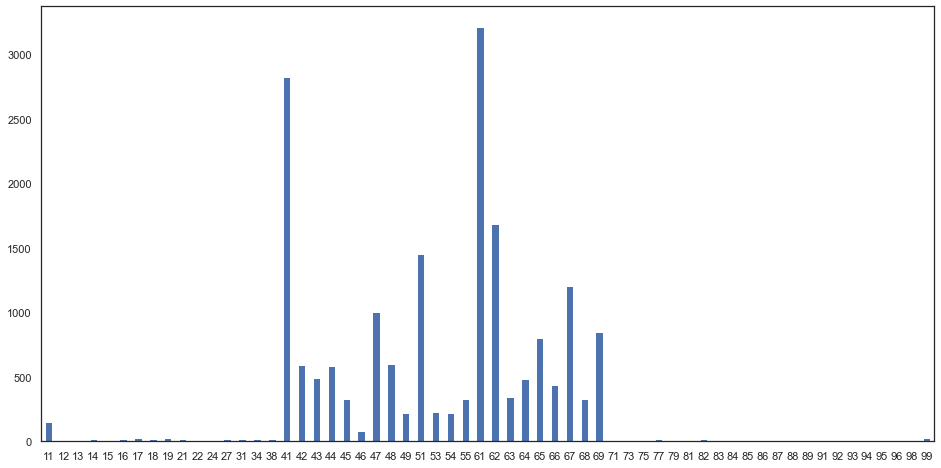

In [31]:
plt.figure(figsize=(16,8)) 
data_acesso.ddd.value_counts().sort_index().plot.bar()
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text major ticklabel objects>)

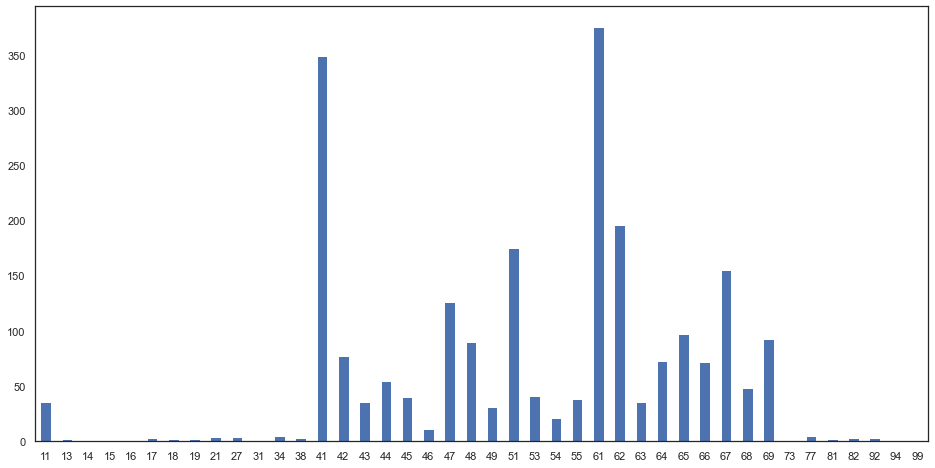

In [33]:
plt.figure(figsize=(16,8)) 
data_acordo.ddd.value_counts().sort_index().plot.bar()
plt.xticks(rotation=0)

Para ddd também temos a mesma distribuição.

In [30]:
#data.qtd_hist_acessos.value_counts()

In [31]:
#data[data['qtd_hist_acessos']>0].count()

77395 clientes com qtd_hist_acessos>0

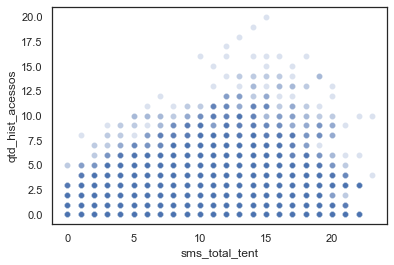

In [32]:
sns.scatterplot(x="sms_total_tent", y="qtd_hist_acessos",alpha=0.2, data=data)

**Vamos usar uma ferramenta de visualização do pandas para entendermos melhor os dados e escolher a direção que vamos tomar.**

In [33]:
#Pandas_profiling provides a detailed report of the data but it is heavy
#import pandas_profiling
#data.profile_report()

A coluna **sms_invalido** não possui entradas diferentes de 0, todos os valores são nulos.

See correlations

In [34]:
pd.DataFrame(abs(data.corr()['acesso']).sort_values(ascending = False))

,acesso
acesso,1.000000
acordo,0.346325
qtd_hist_acessos,0.238260
sms_entregue,0.060827
sms_naoentregue,0.058954
idade,0.026447
sms_total_tent,0.018114
sms_enviado,0.004344
ddd,0.003946
sms_rejeitado,0.001849


In [35]:
pd.DataFrame(abs(data.corr()['acordo']).sort_values(ascending = False))

,acordo
acordo,1.000000
acesso,0.346325
qtd_hist_acessos,0.050224
sms_naoentregue,0.020531
sms_entregue,0.017052
idade,0.007279
sms_total_tent,0.002240
sms_rejeitado,0.000640
ddd,0.000278
sms_enviado,0.000041


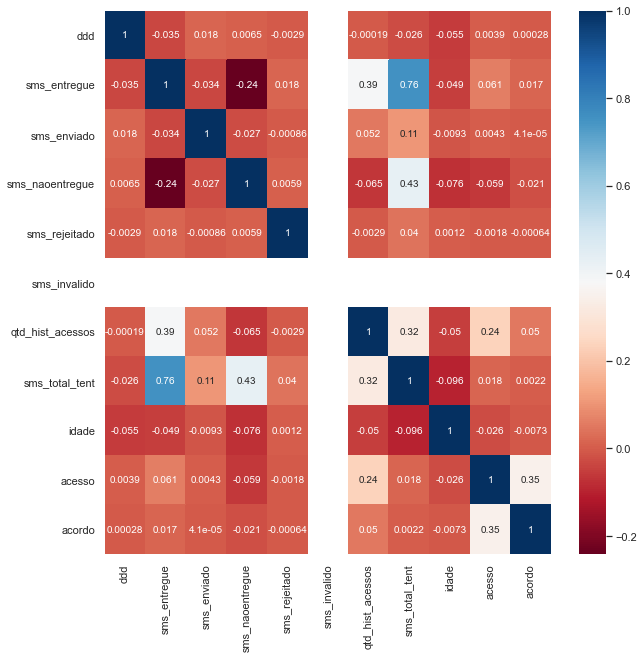

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, cmap="RdBu")

Algumas correlações chamam atenção na tabela, **sms_total_tent** com **qtd_hist_acessos**, **qtd_hist_acessos** com **acessos**, **acessos** com **acordo sms_total_tent** com **sms_entregue** e **sms_naoentregue** e **sms_entregue** com **qtd_hist_tent**, estas parecem ser nossas principais features.

As variáveis categoricas ainda não foram tratadas, vamos vizualizar novamente como elas influenciam as variaveis alvo mais a frente.

## Data Processing

Vamos começar eliminando as 8172 linhas repetidas.

In [37]:
data = data.drop_duplicates()

Vou excluir as 1733 linhas com dados faltando.

In [38]:
data.dropna(subset=['utilizacaoweb','vendedoronline','compradoronline', 'genero'], thresh=4, inplace=True)

In [39]:
total = data.isnull().sum().sort_values(ascending=False)
percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
data_maisantiga_acesso,599102,88.6
data_maisrecente_acesso,599102,88.6
rendaestimada,162329,24.0
idade,2,0.0
acordo,0,0.0
valor,0,0.0
ddd,0,0.0
sms_entregue,0,0.0
sms_enviado,0,0.0
sms_naoentregue,0,0.0


Vamos converter valor da divida de objeto para numero

In [40]:
data['valor'] = data['valor'].str.replace(r',','.')
data['valor'] = data['valor'].astype(float)
data['valor'] = data['valor'].round(2)

Vamos ver quanto dinheiro os clientes estão devendo para o parceiro da BLU.

In [41]:
data['valor'].sum()

181532158.17999998

In [42]:
data[(data['acesso']==1)].valor.sum()

5449632.13

In [43]:
data[(data['acordo']==1)].valor.sum()

455981.82999999996

182 milhões de reais é o valor total da divida dos clientes. Uma média de 268,35 reais pro cliente. O valor mais alto é de 61952,93 reais.
5,4 milhões de reais é o valor total da divida dos clientes que acessaram a plataforma.
456 mil de reais é o valor total da divida dos clientes que fecharam acordo.

In [44]:
#data[data['valor']> 10000.00]

15 pessoas possuem dividas superiores a 10k reais, o mais endividado é um homem de 40 anos, recebeu o primeiro disparo a 24 dias, está com a divida ativa a 4158 dias e recebe salário entre 2 e 4 SM.

Podemos visualizar a distribuição do valor da divida

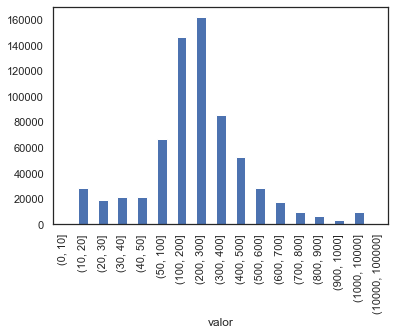

In [45]:
bins = [0,10,20,30,40,50,100,200,300,400,500,600,700,800,900,1000,10000,100000]
df = data.groupby(pd.cut(data['valor'], bins=bins)).valor.count()
df.plot(kind='bar')

Vamos transformar as variaveis categoricas com relaçoes lineares com label encoding, e as categoricas  mutualmente excludentes com one hot enconding. 

Uma observação: já pensando em aplicar algum modelo de árvore de classificação vou transformar os dados faltantes NaN em -999. Essa subtistuição é valida pois talvez podemos identificar um padrão nas entradas com NaN ao invés de simplismente descartar as entradas. O uso de valores numéricos longe do range dos valores numéricos das categorias (1 a 8) não altera o funcionamento dos modelos de árvore de classificação.

In [46]:
# normalize the categories
categorias = {
    "A":  8,
    "B":  7,
    "C":  6,
    "D":  5,
    "E":  4,
    "F" : 3,
    "G":  2,
    "H":  1, 
}
# map the normalized categories to the current categories
data.compradoronline = data.compradoronline.map(categorias)
# view value counts for the normalized titles
#print(data.compradoronline.value_counts())

In [47]:
# normalize the categories
categorias = {
    "A":  8,
    "B":  7,
    "C":  6,
    "D":  5,
    "E":  4,
    "F" : 3,
    "G":  2,
    "H":  1, 
}
# map the normalized categories to the current categories
data.vendedoronline = data.vendedoronline.map(categorias)
# view value counts for the normalized titles
#print(data.compradoronline.value_counts())

In [48]:
# normalize the categories
categorias = {
    "A":  8,
    "B":  7,
    "C":  6,
    "D":  5,
    "E":  4,
    "F" : 3,
    "G":  2,
    "H":  1, 
}
# map the normalized categories to the current categories
data.utilizacaoweb = data.utilizacaoweb.map(categorias)
# view value counts for the normalized titles
#print(data.utilizacaoweb.value_counts())

In [49]:
data.rendaestimada.unique()

array([nan, 'ATE 2 SM', '4 A 10 SM', '2 A 4 SM', 'ACIMA DE 20 SM',
       '10 A 20 SM', 'DE 1 A 1,5 SM', 'SEM INFORMACAO', '1/2 A 1 SM'],
      dtype=object)

In [50]:
# normalize the categories
categorias = {
    "1/2 A 1 SM":  1,
    "DE 1 A 1,5 SM" : 2,
    "ATE 2 SM":  3,
    "2 A 4 SM":  4,
    "4 A 10 SM":  5,
    "10 A 20 SM":  6,
    "ACIMA DE 20 SM":  7,    
    "SEM INFORMACAO": -999, 
}
# map the normalized categories to the current categories
data.rendaestimada = data.rendaestimada.map(categorias)
# view value counts for the normalized titles
print(data.rendaestimada.value_counts())

 3.0      379563
 4.0       77324
 5.0       41904
 6.0        9888
 7.0        5388
-999.0        74
 2.0          26
 1.0           1
Name: rendaestimada, dtype: int64


Vamos substituir os NaN pela mesma label de "SEM INFORMACAO"

In [51]:
data['rendaestimada'] = data['rendaestimada'].fillna(-999)
data['rendaestimada'] = data['rendaestimada'].astype(np.int64)

One Hot encoding

In [52]:
data_cat = data[['genero', 'operadora']]
data_cat_encoded = pd.get_dummies(data_cat)
data = data.join(data_cat_encoded)
data.drop(['genero','operadora'], axis=1, inplace=True)

**Idade** para int, mas antes vamos substituir os 2 numeros faltosos pela mediana

In [53]:
data['idade'] = data['idade'].fillna(data['idade'].median())
data['idade'] = data['idade'].apply(np.int64)

Vamos deletar a coluna **sms_invalido** por não ter nenhuma entrada, talvez em alguma situação o sms pode ser classificado como invalido mas não afetará nossa análise. Para a produção podemos capturar o **sms_invalido** numa nova feature **sms_naorecebido**=**sms_invalido**+**sms_naoentregue**+**sms_rejeitado**

In [54]:
data.drop('sms_invalido', axis=1, inplace=True)

Vamos converter as datas de string para o formato de data

In [55]:
data['datadisparo'] = pd.to_datetime(data['datadisparo'],dayfirst=True)
data['data_atraso'] = pd.to_datetime(data['data_atraso'],dayfirst=True)
data['data_maisrecente_acesso'] = pd.to_datetime(data['data_maisrecente_acesso'],dayfirst=True)
data['data_maisantiga_acesso'] = pd.to_datetime(data['data_maisantiga_acesso'],dayfirst=True)

In [56]:
hoje=pd.datetime.now().date()
print(hoje)

2020-06-15


Vamos calcular o tempo que passou até a data atual das datas de referencia.

In [57]:
data['dias_disparo'] = hoje - pd.to_datetime(data['datadisparo']).dt.date
data['dias_atraso'] = hoje - pd.to_datetime(data['data_atraso']).dt.date
data['dias_maisrecente_acesso'] = hoje - pd.to_datetime(data['data_maisrecente_acesso']).dt.date
data['dias_maisantiga_acesso'] = hoje - pd.to_datetime(data['data_maisantiga_acesso']).dt.date
#data['intervalo_acessos']=pd.to_datetime(data['data_maisrecente_acesso']).dt.date-pd.to_datetime(data['data_maisantiga_acesso']).dt.date
#data_diamesano=data
data.drop(['datadisparo','data_atraso','data_maisrecente_acesso','data_maisantiga_acesso'],axis=1, inplace=True)

In [58]:
data['dias_maisrecente_acesso']=data['dias_maisrecente_acesso'].map(lambda x: np.nan if pd.isnull(x) else x)
data['dias_maisantiga_acesso'] =data['dias_maisantiga_acesso'].map(lambda x: np.nan if pd.isnull(x) else x)
#data['intervalo_acessos']=data['intervalo_acessos'].map(lambda x: np.nan if pd.isnull(x) else x)

In [59]:
data['dias_disparo'] = data['dias_disparo'].astype('timedelta64[D]')
data['dias_atraso'] = data['dias_atraso'].astype('timedelta64[D]')
data['dias_disparo'] = data['dias_disparo'].astype(np.int64)
data['dias_atraso'] = data['dias_atraso'].astype(np.int64)
data['dias_maisrecente_acesso']=data['dias_maisrecente_acesso'].astype('timedelta64[D]')
data['dias_maisantiga_acesso']=data['dias_maisantiga_acesso'].astype('timedelta64[D]')
#data['intervalo_acessos']=data['intervalo_acessos'].astype('timedelta64[D]')

In [60]:
data['dias_maisrecente_acesso']=data['dias_maisrecente_acesso'].fillna(-999)
data['dias_maisantiga_acesso']=data['dias_maisantiga_acesso'].fillna(-999)
#data['intervalo_acessos']=data['intervalo_acessos'].fillna(-999)
data['dias_maisrecente_acesso']=data['dias_maisrecente_acesso'].astype(np.int64)
data['dias_maisantiga_acesso']=data['dias_maisantiga_acesso'].astype(np.int64)
#data['intervalo_acessos']=data['intervalo_acessos'].astype(np.int64)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676497 entries, 0 to 686382
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ddd                      676497 non-null  int64  
 1   sms_entregue             676497 non-null  int64  
 2   sms_enviado              676497 non-null  int64  
 3   sms_naoentregue          676497 non-null  int64  
 4   sms_rejeitado            676497 non-null  int64  
 5   valor                    676497 non-null  float64
 6   qtd_hist_acessos         676497 non-null  int64  
 7   sms_total_tent           676497 non-null  int64  
 8   idade                    676497 non-null  int64  
 9   compradoronline          676497 non-null  int64  
 10  vendedoronline           676497 non-null  int64  
 11  utilizacaoweb            676497 non-null  int64  
 12  rendaestimada            676497 non-null  int64  
 13  acesso                   676497 non-null  int64  
 14  acor

In [62]:
total = data.isnull().sum().sort_values(ascending=False)
percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
dias_maisantiga_acesso,0,0.0
dias_maisrecente_acesso,0,0.0
sms_entregue,0,0.0
sms_enviado,0,0.0
sms_naoentregue,0,0.0
sms_rejeitado,0,0.0
valor,0,0.0
qtd_hist_acessos,0,0.0
sms_total_tent,0,0.0
idade,0,0.0


In [63]:
#data.describe()

A média de dias de atraso da divida é de 1165 dias (3 anos), a divida mais antiga é de 1993, a média entre os acessos é de 3 dias

In [64]:
#data[data['acesso']==1].count()
#data[data['acordo']==1].count()
#data[data['sms_rejeitado']>0].count()
#data[(data['sms_rejeitado']>0) & (data['acesso']>0) ].count()
#data[data['sms_rejeitado']>3]
#data[(data['sms_rejeitado']>3) & (data['ddd']!=51)]
#data[data['sms_rejeitado']>10]
#data[(data['sms_rejeitado']>0) & (data['sms_entregue']>0)]
#data[(data['acesso']==0) & (data['acordo']==1)]
#data[(data['acesso']==1) & (data['qtd_hist_acessos']==0)].count()
#data[(data['acesso']==1) & (data['qtd_hist_acessos']>0)].count()
#data[(data['acesso']==1) & (data['sms_total_tent']==0)].count()
#data[(data['acesso']==1) & (data['acordo']==1)]
#data[(data['acesso']==1) & (data['sms_rejeitado']>0)]
#data[data['sms_naoentregue']>0].count()
#data[(data['acesso']==1) & (data['sms_naoentregue']>0)]
#data[(data['acesso']==1) & (data['sms_naoentregue']>0) & (data['sms_entregue']>0)]
#data[(data['sms_naoentregue']>0) & (data['sms_entregue']>0)]
#data[(data['acesso']==1) & (data['sms_naoentregue']>0) & (data['sms_entregue']>0)].count()

No nosso dataset sem duplicatas temos 18562 acessos e 2316 acordos

Temos muitas colunas sobre sms, que podem ser condensadas através de feature engineering,vamos analisar.  

Para futuros disparos sugiro adotar um limite para que o número da entrada seja marcado como invalido e retirado da ordem. >0, >2 ou >3 me parecem limites razoaveis. Para nosso caso vamos utilizar >0 como limite.

Nenhum **acordo** foi fechado sem **acesso**, o que é natural.

9414 acessos com **qtd_hist_acesso**==0,  9148 acessos com **qtd_hist_acessos**>0, nem todo acesso foi computado, mas das correlações **qtd_hist_acesso** e **acessos** são correlacionados.

4489 acessos com **sms_total_tent**==0, nem todo sms enviado foi computado 

Além disso, para o proximo disparo vamos retirar 2316 entradas que já fecharam **acordo**. Não vamos retira-los agora do dataset por que vamos utilizar esses dados para nosso modelo.

138512 entradas com **sms_naoentregue** > 0

Parece haver inconsistências com as variaveis sms. E **qtd_hist_acesso** e **sms_total_tent** também aprensenta inconsistências mas vamos mante-la para o modelo por apresentarem correlação consideravel. Sugiro verificar como os dados estão sendo computados.

Vamos excluir as entradas que não chegam ao destinatário final e vamos trabalhar com as entradas com telefones válidos.

In [65]:
data=data[data['sms_rejeitado']==0]
data.drop(['sms_rejeitado'], axis=1, inplace=True)
data=data[data['sms_naoentregue']==0]
data.drop(['sms_naoentregue'], axis=1, inplace=True)

Como decidi considerar para reenvio de sms apenas os números válidos e excluir os números problemáticos, vamos dropar as variáveis **sms_entregue**, **sms_enviado** e utilizar **sms_total_tent** como nossa feature sms, e vamos supor que os outros números que ainda não confirmaram recebimento são números válidos.

In [66]:
data.drop(['sms_entregue','sms_enviado'], axis=1, inplace=True)

In [67]:
#data[data['idade']>114].count()
data.loc[data.idade > 114, 'idade'] = 114

Temos 14 entradas com idade acima de 114 anos e vamos substitui-las por 114.

In [68]:
#data[data['idade']<18].count()
data.loc[data.idade <18, 'idade'] = 18

Temos 36 entradas com idade abaixo de 18 e vamos substitui-las por 18.

O dataset é referente a todos os clientes do parceiro, muitos dos quais receberam o primeiro disparo e ainda não foi computado a confirmação de recebimento do sms. Para que possamos aplicar os algoritmos de ML precisamos dos dados históricos. Para tal, vamos selecionar do dataset os clientes que tem **sms_total_tent** > 0. E vamos selecionar do dataset com os números válidos os números que ainda não fecharam acordo para prever para quem devemos mandar sms no próximo disparo.

In [69]:
data_historico = data[data['sms_total_tent']>0]
data_test= data[data['acordo']==0]

In [70]:
#data_hist.info()

322433 clientes que às quais ja foram enviados pelo menos 1 sms

In [71]:
#data_test.info()

535613 clientes que não fecharam acordo ainda.

In [72]:
pd.DataFrame(abs(data_historico.corr()['acesso']).sort_values(ascending = False))

,acesso
acesso,1.000000
acordo,0.340287
qtd_hist_acessos,0.255136
dias_maisantiga_acesso,0.210226
dias_maisrecente_acesso,0.209706
dias_disparo,0.038260
idade,0.029937
rendaestimada,0.019248
valor,0.011370
dias_atraso,0.009570


## Building Machine Learning Models


Vimos que só houve acordo caso **acesso** == 1. O número de acordos é da ordem de 2000, comparado a 600000 clientes no dataset. Como acordo está correlacionado com acesso e muito fracamente relacionado com as outras variáveis, e temos mais informações de acessos, vamos otimizar nosso modelo de ML para acessos, esperando que assim aumentem o número de acordo.

Apesar de termos mais informações sobre acessos, mesmo considerando apenas os dados históricos, ainda sofremos com o desbalanceamento de dados. Dentre das estratégias possíveis vamos utilizar a de **undersampling**, isto é, vamos utilizar todos os dados para acesso==1 e escolher aleatoriamente dados com acesso==0 até termos 50/50.

Para nosso problema, é pior não mandar um sms para um cliente que acessaria a plataforma do que um sms para um cliente que vai ignorar o sms, vamos levar isso em conta em nossa análise de performance.

**Dealing with Unbalanced Data: Undersampling**

In [73]:
from sklearn.utils import resample
#from imblearn.under_sampling import NearMiss

# copying the original data  
resample_data = data_historico

#Separate majority and minority classes
print("No. of 0's and 1's in the feature Class before undersampling the data")
print(resample_data.acesso.value_counts())

data_majority = resample_data[resample_data.acesso==0]
data_minority = resample_data[resample_data.acesso==1]
 
# Downsample majority class
data_majority_undersampled = resample(data_majority, 
                                 replace=False,   
                                 n_samples=14073,   
                                 random_state=5) 
 
# Combine minority class with downsampled majority class
data_undersampled = pd.concat([data_majority_undersampled, data_minority])
 
# Display new class counts
print("No. of 0's and 1's in the feature Class after undersampling the data" )
print(data_undersampled.acesso.value_counts())

data_hist=data_undersampled

No. of 0's and 1's in the feature Class before undersampling the data
0    308360
1     14073
Name: acesso, dtype: int64
No. of 0's and 1's in the feature Class after undersampling the data
1    14073
0    14073
Name: acesso, dtype: int64


**Data is ready for Machine Learning**

In [83]:
# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [75]:
from sklearn.model_selection import train_test_split

target_acesso = data_hist['acesso']
target_acordo = data_hist['acordo']
predictors = data_hist.drop(['acesso','acordo'], axis=1)
x_train, x_val, y_train, y_val = train_test_split(predictors, target_acesso, test_size = 0.2, random_state = 0)

In [76]:
#DecisionTree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

64.21


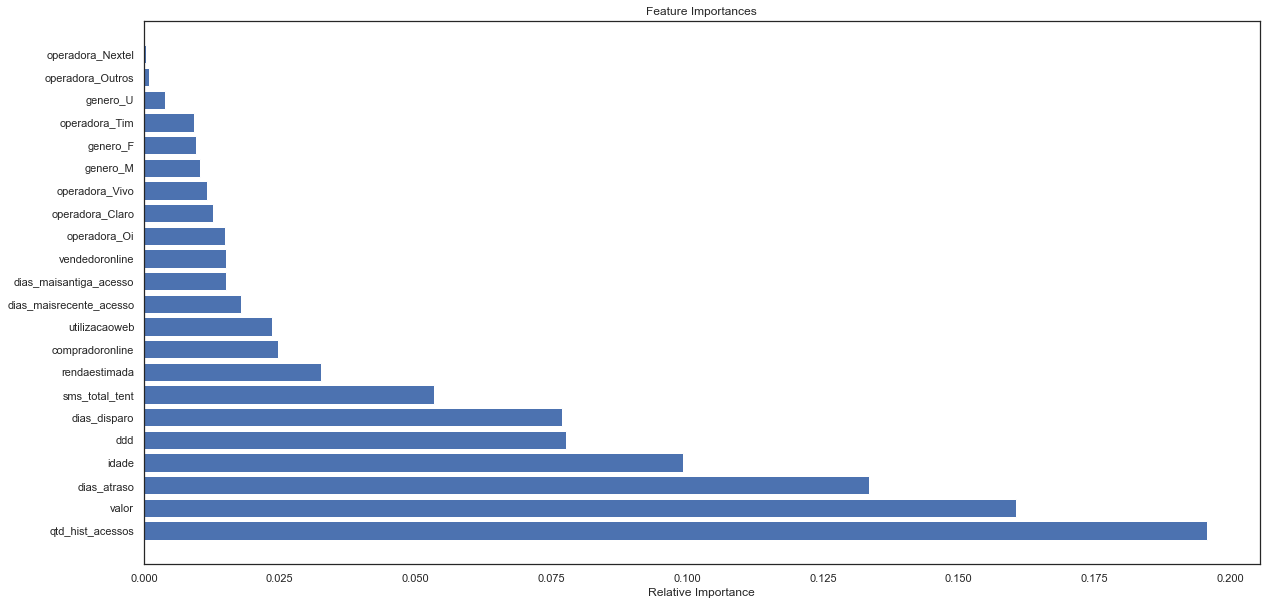

In [77]:
importances = decisiontree.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
features = predictors.columns

plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Operadoras e genero tem uma relative importance baixos, vamos elimina-los.

In [78]:
#Stochastic Gradient Descent (SGD)
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
sgd.score(x_train, y_train)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)

61.07


In [84]:
#Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)

Y_prediction = random_forest.predict(x_val)

random_forest.score(x_train, y_train)
acc_rf = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_rf)

61.07


In [85]:
#logistic regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_val)

acc_log = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_log)

71.58


In [86]:
#KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)  
y_pred = knn.predict(x_val)  
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

66.0


In [87]:
#Probabilistic classification Gaussian Naive Bayes
gaussian = GaussianNB() 
gaussian.fit(x_train, y_train)  
y_pred = gaussian.predict(x_val)  
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

71.56


In [88]:
results = pd.DataFrame({
    'Model': ['DecisionTree','Stochastic Gradient Descent (SGD)','Random Forest','logistic regression','KNN','Gaussian Naive Bayes'],
    'Score': [acc_decisiontree,acc_sgd,acc_rf,acc_log,acc_knn,acc_gaussian]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
71.58,logistic regression
71.56,Gaussian Naive Bayes
66.00,KNN
64.21,DecisionTree
61.07,Stochastic Gradient Descent (SGD)
61.07,Random Forest


Vamos elimiar as features com baixa importance e retreinar o modelo com melhor performance.

In [89]:
data_hist=data_hist.drop(['operadora_Claro','operadora_Nextel','operadora_Oi','operadora_Outros','operadora_Tim','operadora_Vivo','genero_F', 'genero_M', 'genero_U'], axis=1)
data_test=data_test.drop(['operadora_Claro','operadora_Nextel','operadora_Oi','operadora_Outros','operadora_Tim','operadora_Vivo','genero_F', 'genero_M', 'genero_U'], axis=1)

In [90]:
predictors = data_hist
x_train, x_val, y_train, y_val = train_test_split(predictors, target_acesso, test_size = 0.2, random_state = 0)

In [91]:
#logistic regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_val)

acc_log = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_log)

84.14


**K-Fold Cross Validation**

Vamos calcular o score para 5 K-Fold CV

In [92]:
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression()
scores = cross_val_score(logreg, x_train, y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.77109236 0.79635798 0.81434599 0.82989118 0.81345769]
Mean: 0.8050290431995405
Standard Deviation: 0.02001429142593686


Desempenho médio de 81%

In [93]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(logreg, x_train, y_train, cv=3)
confusion_matrix(y_train, predictions)

array([[9799, 1502],
       [2707, 8508]], dtype=int64)

Onde: linhas verdade, colunas predição
linha 1: True Positives,False Positives.
linha 2: False Negatives,True Negatives.

In [94]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train, predictions))
print("Recall:",recall_score(y_train, predictions))

Precision: 0.84995004995005
Recall: 0.7586268390548373


In [95]:
from sklearn.metrics import f1_score
f1_score(y_train, predictions)

0.801696113074205

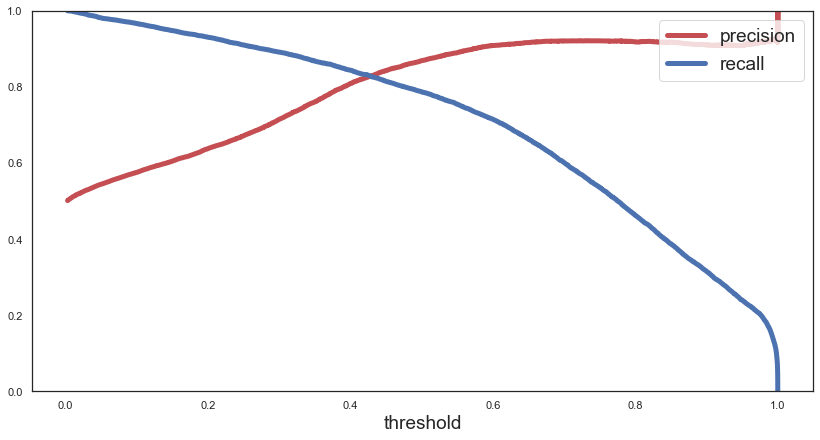

In [97]:
from sklearn.metrics import precision_recall_curve

logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)

# getting the probabilities of our predictions
y_scores = logreg.predict_proba(x_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

No nosso caso recall é mais importante, queros aumentar o número de true positives mesmo que nisso sejam incluidos falsos positivos.

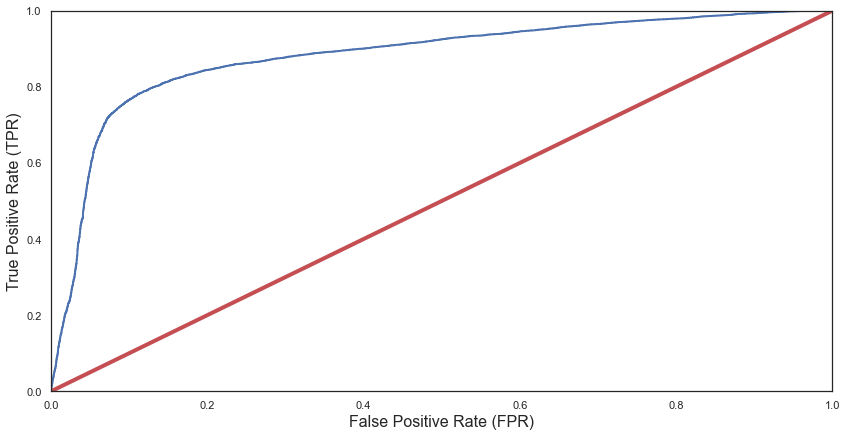

In [98]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

A linha vermelha é totalmente aleatório, i.e. lançamento de moeda e a linha azul é nosso modelo.

In [99]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.8817526790818562


**Time to predict**

Para prever nosso resultado vamos considerar que entre um disparo e outro passam-se 15 dias e vamos atualizar o número de **sms_total_tent**. Vamos prever nosso output como probabilidade.

In [100]:
data_test['dias_disparo']=15
data_test['sms_total_tent']=data_test['sms_total_tent']+1

In [101]:
predictions = logreg.predict_proba(data_test)[:,1]

In [102]:
previsao = pd.DataFrame({ 'Cliente' : data_test.index, 'previsao_acesso': predictions.astype('float64') })
#previsao.to_csv('previsao.csv', index=False)

In [103]:
previsao[(previsao['previsao_acesso']>0)]

,Cliente,previsao_acesso
0,0,0.250848
1,1,0.069189
2,2,0.188280
3,3,0.304674
4,6,0.232820
...,...,...
535608,686373,0.134401
535609,686378,0.144954
535610,686380,0.065391
535611,686381,0.293058


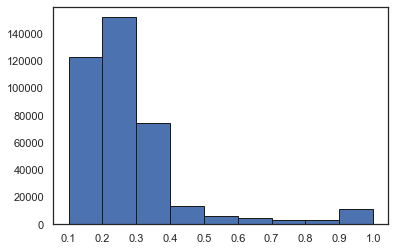

In [104]:
bins= [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
plt.hist(previsao['previsao_acesso'], bins=bins, edgecolor="k")
plt.xticks(bins)
plt.show()

In [107]:
previsao['previsao_acesso'].groupby(pd.cut(previsao['previsao_acesso'], np.arange(0, 1.1, 0.1))).count()

previsao_acesso
(0.0, 0.1]    144927
(0.1, 0.2]    122613
(0.2, 0.3]    151905
(0.3, 0.4]     74034
(0.4, 0.5]     13286
(0.5, 0.6]      6194
(0.6, 0.7]      4916
(0.7, 0.8]      3214
(0.8, 0.9]      3428
(0.9, 1.0]     11096
Name: previsao_acesso, dtype: int64

In [106]:
#previsao[(previsao['previsao_acesso']>0.3)]
#previsao[(previsao['previsao_acesso']>0.5)]
#previsao[(previsao['previsao_acesso']>0.8)]

42220 clientes que nosso modelo calculou tem mais de 50% de chance de acessar a plataforma e 16808 com 80% de chance e 116168 com 30% de chance de acesso após 15 dias de um novo envio. Como o output é um probabilidade, podemos escolher de acordo com a probabilidade, ou orderar e escolher os n melhores valores de acordo com nosso orçamento e numero total de sms a serem mandados.

**Conclusão**

Através da EDA, conhecemos o perfil dos clientes, dos que acessam e fecham acordo,<br>
o valor total das dívidas à serem negociadas,<br>
as principais operadoras com as quais podemos buscar diminuir o custo unitário do sms,<br>
identificamos pontos a serem melhorados no dataset,<br>
e implementamos um modelo pensado para ser reusado sempre que necessário, que nos auxilie na seleção dos que devem receber o sms no próximo disparo.

Próximo passo:

Calibrar os hiperparametros do modelo<br>
Explorar outras soluções para desbalanceamento de dados<br>
Testar para outros algoritmos como redes neurais<br>
Melhorar a qualidade dos dados do dataset<br>
Atualizar os dados com as confirmações dos sms do último disparo<br>
Buscar mais dados seja nos dados históricos antigos, seja nos dados atualizados, seja usando os dados dos outros parceiros.<br>